# 6. Decision Trees and Ensemble Learning

## 6.1 Credit risk scoring project

- `Dataset`: https://github.com/gastonstat/CreditScoring

| **`Column`** | **`Meaning`**              |
| ------------ | -------------------------- |
| 1 Status	   | credit status              |
| 2 Seniority  | job seniority (years)      |
| 3 Home       | type of home ownership     |
| 4 Time       | time of requested loan     |
| 5 Age        | client's age               |
| 6 Marital    | marital status             |
| 7 Records    | existance of records       |
| 8 Job        | type of job                |
| 9 Expenses   | amount of expenses         |
| 10 Income    | amount of income           |
| 11 Assets    | amount of assets           |
| 12 Debt      | amount of debt             |
| 13 Amount    | amount requested of loan   |
| 14 Price     | price of good              | 

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

## 6.2 Data cleaning and preparation

- Download ing the dataset
- Re-encoding the categorical variables
- Doing the train / validation / test split

### Downloading the dataset

In [2]:
# data = "https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv"
# !wget -c $data

In [3]:
df = pd.read_csv("CreditScoring.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4455 entries, 0 to 4454
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Status     4455 non-null   int64
 1   Seniority  4455 non-null   int64
 2   Home       4455 non-null   int64
 3   Time       4455 non-null   int64
 4   Age        4455 non-null   int64
 5   Marital    4455 non-null   int64
 6   Records    4455 non-null   int64
 7   Job        4455 non-null   int64
 8   Expenses   4455 non-null   int64
 9   Income     4455 non-null   int64
 10  Assets     4455 non-null   int64
 11  Debt       4455 non-null   int64
 12  Amount     4455 non-null   int64
 13  Price      4455 non-null   int64
dtypes: int64(14)
memory usage: 487.4 KB


In [5]:
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


The categorical variable are alread encoded as numerical values. This is useful for machine learning model, however the readability for humans is very low. It would be good to find out what categorical values the numbers are encoding. 

Transforming the column-header

In [6]:
df.columns = df.columns.str.lower()

Preprocessing of the data was done with the following R-file: [Part1_CredScoring_Processing.R](https://github.com/gastonstat/CreditScoring/blob/master/Part1_CredScoring_Processing.R)

### Re-encoding the categorical variables

Relevant code:
```R
# change factor levels (i.e. categories)
levels(dd$Status) = c("good", "bad")
levels(dd$Home) = c("rent", "owner", "priv", "ignore", "parents", "other")
levels(dd$Marital) = c("single", "married", "widow", "separated", "divorced")
levels(dd$Records) = c("no_rec", "yes_rec")
levels(dd$Job) = c("fixed", "partime", "freelance", "others")
```

In [7]:
status_values = {
    1: "ok", 
    2: "default",
    0: "unk"
}
df["status"] = df["status"].map(status_values)

home_values = {
    1: "rent",
    2: "owner",
    3: "private",
    4: "ignore",
    5: "parents",
    6: "other",
    0: "unk"
}
df["home"] = df["home"].map(home_values)

marital_values = {
    1: "single",
    2: "married",
    3: "widow",
    4: "separated",
    5: "divorced",
    0: "unk"
}
df["marital"] = df["marital"].map(marital_values)

records_values = {
    1: "no",
    2: "yes",
    0: "unk"
}
df["records"] = df["records"].map(records_values)

job_values = {
    1: "fixed",
    2: "partime",
    3: "freelance",
    4: "others",
    0: "unk"
}
df["job"] = df["job"].map(job_values)

In [8]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


**Handling missing values**

In [9]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


The `max`-values of `income`, `assests` and `debt` are $99999999$, which was set in the `R`-program mentioned above. This has to be replaced with an adequate value like `np.nan`.

In [10]:
for c in ["income", "assets", "debt"]:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

In [11]:
# The 99999999-values as max are gone now 
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


Removing the customer with unknown statue `unk`

In [12]:
df = df[df["status"] != "unk"].reset_index(drop=True)

Filling in NaN-values

In [13]:
print("Before: ", df.assets.isna().sum().sum())
df = df.fillna(0)
print("After: ", df.assets.isna().sum().sum())

Before:  47
After:  0


### Doing the train / validation / test split

In [14]:
from sklearn.model_selection import train_test_split
rs = 11

In [15]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=rs)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=rs)

print(f"train: {len(df_train)} | {len(df_train) / len(df)*100:.0f}%")
print(f"val: {len(df_val)} | {len(df_val) / len(df)*100:.0f}%")
print(f"test: {len(df_test)} | {len(df_test) / len(df)*100:.0f}%")


train: 2672 | 60%
val: 891 | 20%
test: 891 | 20%


In [16]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [17]:
# obtaining the target-values that are used for the machine learning model. default -> 1, ok -> 0 
y_train = (df_train["status"] == "default").astype("int").values
y_val   = (df_val["status"] == "default").astype("int").values
y_test  = (df_test["status"] == "default").astype("int").values

In [18]:
# removing the target-values from the data
if "status" in df_train.columns:
    df_train.drop(["status"], axis=1, inplace=True)
if "status" in df_val.columns:
    df_val.drop(["status"], axis=1, inplace=True)
if "status" in df_test.columns:
    df_test.drop(["status"], axis=1, inplace=True)

The pre-processing is done and a machine learning model can be trained with it.

## 6.3 Decision Trees

- How a decision tree looks like
- Training a decision tree
- Overfitting
- Controlling the size of a tree

## How a decision tree looks like

- Series of binary decisions arranged in a tree structure

![decision-tree](../imgs/decision_tree.png)

In [19]:
def assess_risk(client):
    if client["records"] == "yes":
        if client["job"] == "parttime":
            return "default"
        else:
            return "ok"
    else:
        if client["assets"] > 6000:
            return "ok"
        else:
            return "default"

In [20]:
xi = df_train.iloc[0].to_dict()
xi

{'seniority': 10,
 'home': 'owner',
 'time': 36,
 'age': 36,
 'marital': 'married',
 'records': 'no',
 'job': 'freelance',
 'expenses': 75,
 'income': 0.0,
 'assets': 10000.0,
 'debt': 0.0,
 'amount': 1000,
 'price': 1400}

In [21]:
assess_risk(xi)

'ok'

Rules can be learned from the data instead of beeing hard-coded as a function. For learning a decision tree, `scikit-learn` can be used. 

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

Input-Preprocessing of data

In [23]:
train_dicts = df_train.to_dict(orient="records")

In [24]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [25]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [26]:
val_dicts = df_val.to_dict(orient="records")
X_val = dv.transform(val_dicts)

In [27]:
y_pred = dt.predict_proba(X_val)[:, 1]

In [28]:
print(f"AUC(val) = {roc_auc_score(y_val, y_pred):.4f}")

AUC(val) = 0.6486


Computing the AUC on the training data

In [29]:
y_pred = dt.predict_proba(X_train)[:, 1]
print(f"AUC(val) = {roc_auc_score(y_train, y_pred):.4f}")

AUC(val) = 1.0000


What is this? 1.0 AUC-score on training-data and only 0.65 AUC-score on validation-data. There is a problem, which is called `overfitting`.

### Problem of Overfitting

- Appears when a model tries to perfectly memorize the training data
- Bad generalization to new data, that is not in the training data

- **How does this appear in the decision tree?**
    - A decision tree constructs a rule of conditions for every record in the dataset
    - This is caused by letting the decision tree grow very deep. Very deep decision trees are able to perfectly learn to fit to any data
- **How can overfitting been avoided?**
    - Restricting the depth of trees

**Using different `max_depth`-values**:

In [30]:
max_depth = 2

In [31]:
dt = DecisionTreeClassifier(max_depth=max_depth)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

In [32]:
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print(f"AUC(train): {auc:.4f}")

y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print(f"AUC(val): {auc:.4f}")

AUC(train): 0.7055
AUC(val): 0.6685


### Looking into the learned decision tree

In [33]:
from sklearn.tree import export_text
import sklearn.tree as tree

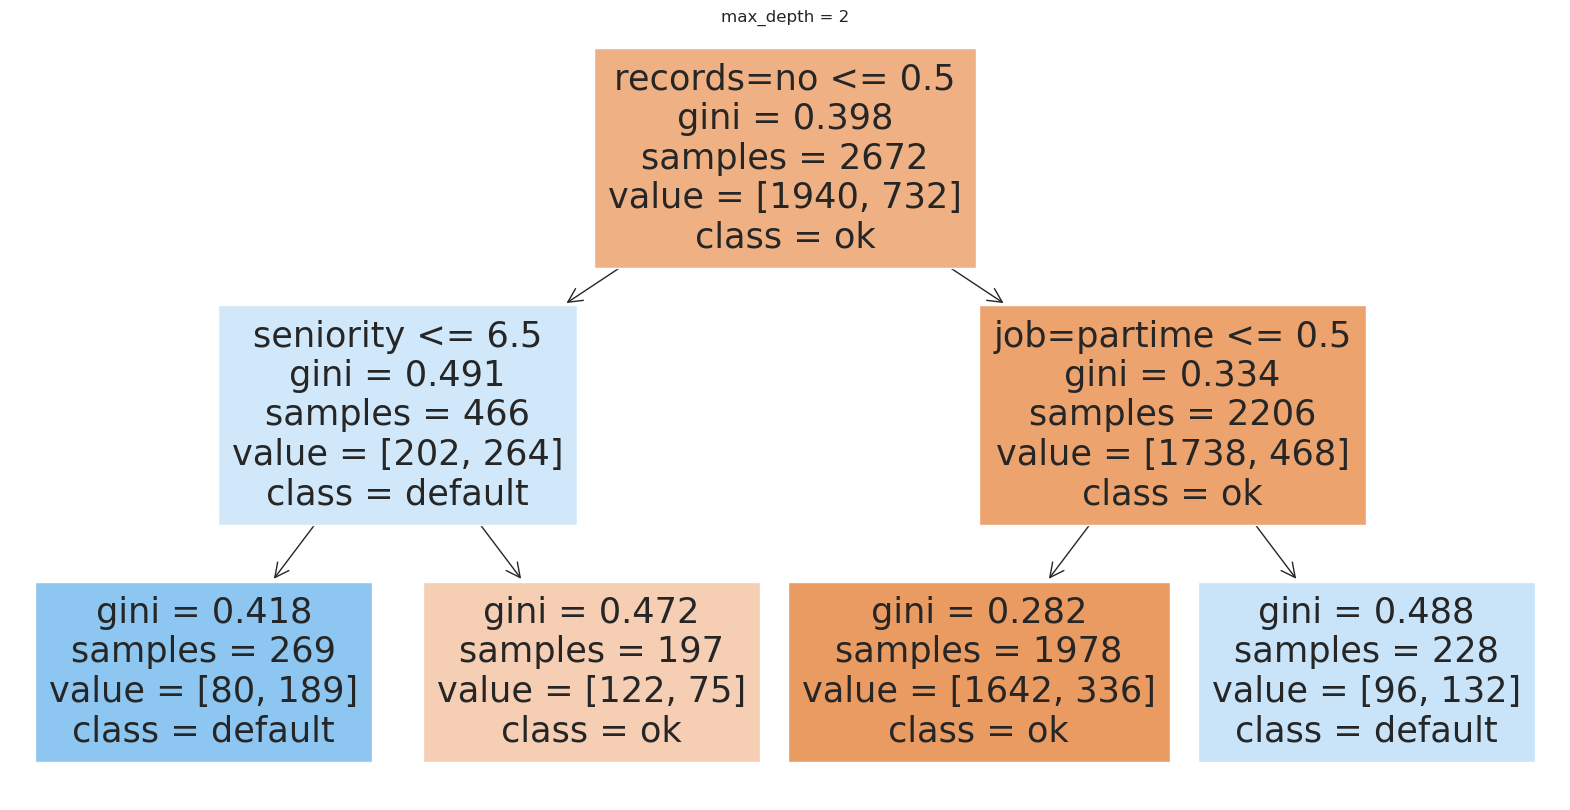

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- class: 0
|--- records=no >  0.50
|   |--- job=partime <= 0.50
|   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- class: 1



In [34]:
feature_names = list(dv.get_feature_names_out())

plt.figure(figsize=(20, 10))
_ = tree.plot_tree(dt, filled=True, feature_names=feature_names, class_names=["ok", "default"]) # 0 -> ok, 1 -> default
plt.title(f"max_depth = {max_depth}")
plt.show()
print(export_text(dt, feature_names=dv.get_feature_names_out()))

The model does not overfit anymore and has drastically imporoved it's AUC-score on the validation-data.

## 6.4 Decision Tree learning algorithm

- Finding the best split for one column
- Finding the best split for the entire dataset
- Stopping criteria
- Decision Tree learning algorithm

### Finding the best split for one column

Creating an example dataset

In [35]:
data = [
    [8000, "default"],
    [2000, "default"],
    [   0, "default"],
    [5000, "ok"], 
    [5000, "ok"], 
    [4000, "ok"], 
    [9000, "ok"], 
    [3000, "default"]
]

df_example = pd.DataFrame(data, columns=["assets", "status"])
df_example

,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


Finding the best split (threshold) for the feature `assets` 

In [36]:
df_example.sort_values(by="assets")

,assets,status
2,0,default
1,2000,default
7,3000,default
5,4000,ok
4,5000,ok
3,5000,ok
0,8000,default
6,9000,ok


The thresholds $0$ and $9000$ are not useful. Therefore the set of possible thresholds is $T \in \{2000, 3000, 4000, 5000, 8000\}$. The determined threshold then splits the values of a feature in `LEFT` and `RIGHT`. Lets test out each thresholds mentioned before.

In [37]:
from IPython.display import display

In [38]:
Ts = [2000, 3000, 4000, 5000, 8000]

In [39]:
for T in Ts:
    df_left  = df_example[df_example["assets"] <= T]
    df_right = df_example[df_example["assets"]  > T]

    print(f"T = {T}")
    print("LEFT:")
    display(df_left)
    print("RIGHT:")
    display(df_right)

T = 2000
LEFT:


,assets,status
1,2000,default
2,0,default


RIGHT:


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


T = 3000
LEFT:


,assets,status
1,2000,default
2,0,default
7,3000,default


RIGHT:


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok


T = 4000
LEFT:


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


RIGHT:


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


T = 5000
LEFT:


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


RIGHT:


,assets,status
0,8000,default
6,9000,ok


T = 8000
LEFT:


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


RIGHT:


,assets,status
6,9000,ok


But what of those possible splits is the best?

In [40]:
# Lets try out T = 4000
T = 4000

df_left  = df_example[df_example["assets"] <= T]
df_right = df_example[df_example["assets"]  > T]

print(f"T = {T}")
print("LEFT:")
display(df_left)
print(df_left["status"].value_counts(normalize=True))

print("RIGHT:")
display(df_right)
print(df_right["status"].value_counts(normalize=True))

T = 4000
LEFT:


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64
RIGHT:


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64


**Computing the Missclassification Rate**
1. Missclassification Rate in `LEFT` - Should be `default`: $1/4 = 25\\%$
2. Missclassification Rate in `RIGHT` - Should be `ok`: $1/4 = 25\\%$
3. Computing the Average of both values which is 25% here ($\frac{1}{2}(0.25 + 0.25) = 0.25$)

The steps above are done for each possible threshold. This is to find the best (least worse) threshold for splitting a certain feature. In step `3.` a weighted average is used, however because of simplicity a regular average is chosen here!

### Missclassification Rate (Impurity)

The missclassifcation rate (also called impurity) is a metric to assess the "goodness" of a split. The goal is to find the least impure split s.t. the resulting splits `LEFT` and `RIGHT` are as homogenuous as possible.

Finding the best threshold $T$:
1. Iterate through all available $T$'s
2. Perform the `LEFT/RIGHT`-split for each $T$ 
3. Measure the impurity of each $T$
4. Choose the $T$ with the lowest impurity

In [41]:
Ts = [0, 2000, 3000, 4000, 5000, 8000]
for T in Ts:
    print(f"T = {T}")

    df_left  = df_example[df_example["assets"] <= T]
    df_right = df_example[df_example["assets"]  > T]

    print("LEFT:")
    display(df_left)
    print(df_left["status"].value_counts(normalize=True))
    
    print("RIGHT:")
    display(df_right)
    print(df_right["status"].value_counts(normalize=True))

    # `DECISION LEFT` | `IMPURITY LEFT` | `DECISION RIGHT` | `IMPURITY RIGHT` | `AVG`
    decision_left = df_left["status"].value_counts().sort_values(ascending=False).index[0]
    impurity_left = df_left["status"][df_left["status"] != decision_left].count() / len(df_left["status"])

    decision_right = df_right["status"].value_counts().sort_values(ascending=False).index[0]
    impurity_right = df_right["status"][df_right["status"] != decision_right].count() / len(df_right["status"])

    node_avg = (impurity_left + impurity_right) / 2.0
    print(f"T: {T} | LEFT-D: {decision_left} | LEFT-IMP: {impurity_left.round(3)} | " \
          f"RIGHT-D: {decision_right} | RIGHT-IMP: {impurity_right.round(3)} | AVG: {node_avg.round(3)}")

    print("\n\n")



T = 0
LEFT:


,assets,status
2,0,default


status
default    1.0
Name: proportion, dtype: float64
RIGHT:


,assets,status
0,8000,default
1,2000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64
T: 0 | LEFT-D: default | LEFT-IMP: 0.0 | RIGHT-D: ok | RIGHT-IMP: 0.429 | AVG: 0.214



T = 2000
LEFT:


,assets,status
1,2000,default
2,0,default


status
default    1.0
Name: proportion, dtype: float64
RIGHT:


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64
T: 2000 | LEFT-D: default | LEFT-IMP: 0.0 | RIGHT-D: ok | RIGHT-IMP: 0.333 | AVG: 0.167



T = 3000
LEFT:


,assets,status
1,2000,default
2,0,default
7,3000,default


status
default    1.0
Name: proportion, dtype: float64
RIGHT:


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64
T: 3000 | LEFT-D: default | LEFT-IMP: 0.0 | RIGHT-D: ok | RIGHT-IMP: 0.2 | AVG: 0.1



T = 4000
LEFT:


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64
RIGHT:


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64
T: 4000 | LEFT-D: default | LEFT-IMP: 0.25 | RIGHT-D: ok | RIGHT-IMP: 0.25 | AVG: 0.25



T = 5000
LEFT:


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64
RIGHT:


,assets,status
0,8000,default
6,9000,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64
T: 5000 | LEFT-D: default | LEFT-IMP: 0.5 | RIGHT-D: default | RIGHT-IMP: 0.5 | AVG: 0.5



T = 8000
LEFT:


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64
RIGHT:


,assets,status
6,9000,ok


status
ok    1.0
Name: proportion, dtype: float64
T: 8000 | LEFT-D: default | LEFT-IMP: 0.429 | RIGHT-D: ok | RIGHT-IMP: 0.0 | AVG: 0.214





The resulting thresholds and their impurity-score can be seen here:

| $T$    | `DECISION LEFT` | `IMPURITY LEFT` | `DECISION RIGHT` | `IMPURITY RIGHT` | `AVG`   |
| ------ | --------------- | --------------- | ---------------- | ---------------- | ------- |
| $0$    | `DEFAULT`       |   $0\\%$        | `OK`             | $43\\%$          | $21\\%$ |
| $2000$ | `DEFAULT`       |   $0\\%$        | `OK`             | $33\\%$          | $16\\%$ |
| $3000$* | `DEFAULT`       |   $0\\%$        | `OK`             | $20\\%$          | $10\\%$ |
| $4000$ | `DEFAULT`       |   $25\\%$       | `OK`             | $25\\%$          | $25\\%$ |
| $5000$ | `DEFAULT`       |   $50\\%$       | `OK`             | $50\\%$          | $50\\%$ |
| $8000$ | `DEFAULT`       |   $43\\%$       | `OK`             |  $0\\%$          | $21\\%$ |

From the results we can see, that the thresold of $T^* = 3000$ leads to the least impure separation of the assets-features. We therefore choose this as the threshold for the current node of the decision tree. 

### Another try! This time with two features instead of one

In [42]:
data = [
    [8000, 3000, "default"],
    [2000, 1000, "default"],
    [   0, 1000, "default"],
    [5000, 1000, "ok"], 
    [5000, 1000, "ok"], 
    [4000, 1000, "ok"], 
    [9000,  500, "ok"], 
    [3000, 2000, "default"]
]

df_example = pd.DataFrame(data, columns=["assets", "debt", "status"])
df_example

,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


In [43]:
df_example.sort_values(by="debt")

,assets,debt,status
6,9000,500,ok
1,2000,1000,default
3,5000,1000,ok
2,0,1000,default
5,4000,1000,ok
4,5000,1000,ok
7,3000,2000,default
0,8000,3000,default


Possible `T`'s can be $T_{debt}\in\{500, 1000, 2000\}$

In [44]:
# using the previously used thresholds for assets and debt
thresholds = { 
    "assets": [0, 2000, 3000, 4000, 5000, 8000],
    "debt": [500, 100, 2000]
}

In [45]:
for feature, Ts in thresholds.items():
    print("\n===========================")
    print("Feature: ", feature)
    for T in Ts:
        print("T = ", T)
        df_left = df_example[df_example[feature] <= T]
        df_right = df_example[df_example[feature] > T]

        display(df_left)
        print(df_left["status"].value_counts(normalize=True))
        display(df_right)
        print(df_right["status"].value_counts(normalize=True))



    print("===========================")



Feature:  assets
T =  0


,assets,debt,status
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64
T =  2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64
T =  3000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
7,3000,2000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64
T =  4000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
5,4000,1000,ok
7,3000,2000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
6,9000,500,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64
T =  5000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
6,9000,500,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64
T =  8000


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,assets,debt,status
6,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64

Feature:  debt
T =  500


,assets,debt,status
6,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64
T =  100


,assets,debt,status


Series([], Name: proportion, dtype: float64)


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64
T =  2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default


status
default    1.0
Name: proportion, dtype: float64


By extending the table from the single-feature decision tree we get:

| $T$    | `DECISION LEFT` | `IMPURITY LEFT` | `DECISION RIGHT` | `IMPURITY RIGHT` | `AVG`   |
| :----: | :-------------: | :-------------: | :--------------: | :--------------: | :-----: |
| $T_{assets}$ |           |                 |                  |                  |         |
| $0$    | `DEFAULT`       |   $0\\%$        | `OK`             | $43\\%$          | $21\\%$ |
| $2000$ | `DEFAULT`       |   $0\\%$        | `OK`             | $33\\%$          | $16\\%$ |
| $3000$*| `DEFAULT`       |   $0\\%$        | `OK`             | $20\\%$          | $10\\%$ |
| $4000$ | `DEFAULT`       |   $25\\%$       | `OK`             | $25\\%$          | $25\\%$ |
| $5000$ | `DEFAULT`       |   $50\\%$       | `OK`             | $50\\%$          | $50\\%$ |
| $8000$ | `DEFAULT`       |   $43\\%$       | `OK`             |  $0\\%$          | $21\\%$ |
| $T_{debt}$ |             |                 |                  |                  |         |
| $500$  | `OK`            |   $0\\%$        | `DEFAULT`        | $43\\%$          | $21\\%$ |
| $1000$ | `OK`            |   $33\\%$       | `DEFAULT`        | $33\\%$          | $16\\%$ |
| $2000$ | `OK`            |   $43\\%$       | `DEFAULT`        | $20\\%$          | $21\\%$ |

The split along the thresholds of the `debt`-feature did not yield a better result. Therefore the best splitting feature is `assets` with a threshold $T^* = 3000$

### Finding the best split for the entire dataset

**Finding the best split algorithm**:

```python
# iterate over all features
for f in features:
    # try out all possible thresholds for a feature
    thresholds = find_all_thresholds(f)
    for T in thresholds:
        # split dataset using "f > T"-condition
        # Compute `Impurity` of the split

# Select condition with lowest impirity
```

![dt_recursion](../imgs/dt_recursion.jpg)

After finding the best split for a node, the algorithm is also applied to the leafs of the current node. However this could continue indefinitely (leading to overfitting) and therefore requires a stopping criteria to work properly.

### Stopping criteria

Some relevant stopping criteria, that could be used are
- Group already `PURE` (only one category present)
- Tree reached depth-limit (`max_depth`-parameter)
- Gruop too small to split

### Decision Tree learning algorithm

The following algorithm is only a rough sketch of the real algorithm which can be found at the scikit-learn website [here](https://scikit-learn.org/stable/modules/tree.html).

- Find the best split
- Stop if `max_depth` is reached
- If `LEFT` is sufficiently large and `NOT PURE`
    - Repeat for `LEFT`
- If `RIGHT` is sufficiently large and `NOT PURE`
    - Repeat for `RIGHT`

## 6.5 Decision Trees parameter tuning

- selecting `max_depth`
- selecting `min_samples_leaf`

### Parameters in DecisionTreeClassifier

```python
DecisionTreeClassifier(
    *,
    criterion="gini",
    splitter="best",
    max_depth=None,     # <- for constraining the depth of the decision tree
    min_samples_split=2,
    min_samples_leaf=1,  # <- specifies the minimum size of agroup inside a leaf
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    class_weight=None,
    ccp_alpha=0.0,
)
```

In [46]:
results = []

for d in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    dt = DecisionTreeClassifier(max_depth=d)
    dt.fit(X_train, y_train)

    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    results.append((d, auc))
    print(f"{str(d):4} -> {auc:.3f}")

results = np.array(results)
best_result = results[np.argmax(results[:, -1])]
best_d, best_auc = best_result
print(f"\nd* = {float(best_d)} | auc* = {best_auc:.3f}")

1    -> 0.606
2    -> 0.669
3    -> 0.739
4    -> 0.761
5    -> 0.767
6    -> 0.760
10   -> 0.693
15   -> 0.670
20   -> 0.646
None -> 0.654

d* = 5.0 | auc* = 0.767


The parameter `max_depth=5` yielded the best result, however the depths 4 and 6 are also reasonably close to the best value. Here `max_depth=4` should be chosen, since it uses a less complex decision tree. We however still retain the `max_depth`-values in the evaluation in order to see how the result changes for different `min_samples_leaf`-values.

In [47]:
results = []

for d in [4, 5, 6]: # [4, 5, 6, 7, 10, 15, 20, None]:
    for s in [1, 2, 5, 10, 15, 20, 100, 200, 500]:
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
        dt.fit(X_train, y_train)
        
        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        # print(f"({str(d)}, {s}) -> {auc:.4f}")
        results.append((d, s, auc))

df_scores = pd.DataFrame(results, columns=["max_depth", "min_samples_leaf", "auc"])
df_scores.sort_values(by="auc", ascending=False).head()

,max_depth,min_samples_leaf,auc
22,6,15,0.785080
21,6,10,0.778299
24,6,100,0.776434
23,6,20,0.774279
14,5,20,0.774028


In [48]:
df_scores_pivot = df_scores.pivot(index="min_samples_leaf", columns=["max_depth"],
                                  values=["auc"])


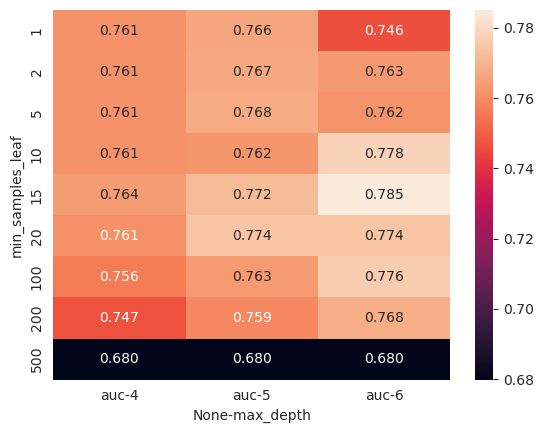

In [49]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")
plt.show()

From the plot above we can see that the combination `max_depth=6` and `min_samples_leaf=15` result in the highest `AUC`-value. This solution could be still suboptimal, since not all possible combinations were explored, however this is not always feasible, because of the size / complexity of a dataset. In such situations, the tuning of single parameters is advisable in order to constraint the search space for other parameter. In a problem of 2 variables with 3 & 5 values they could take on, this could reduce the iterations from 3 * 5 = 15 to 1 * 5 = 5.

In [50]:
# The model-configuration, that is proceeded with
md = 6
msl = 15
dt = DecisionTreeClassifier(max_depth=md, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

## 6.6 Ensembles and random forest

- Board of experts
- Ensemble models
- Random forest - ensembling decision trees
- Tuning random forest

### Board of experts

Uses a board of experts (trained models), that have different configurations. They then are aggregated to use the consensus of the experts as the prediction. The decision trees have random configurations from a prescribed set of possiblities. The resulting set of random decision trees is called a `Random Forest`.

In the following example there are 10 possible configurations for features in the model and every model uses 7 of them randomly:

<img src="../imgs/rf.jpg" style="width: 700px"/>
<!-- ![rf](../imgs/rf.jpg) -->


An example of a `board of experts` with 3 randomly selected features can be seen in the following graphic:
<img src="../imgs/boe.jpg" style="width: 700px"/>



In [51]:
from sklearn.ensemble import RandomForestClassifier

In [52]:
rf = RandomForestClassifier(n_estimators=10, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=1)

In [53]:
y_pred = rf.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print(f"AUC(RF): {auc}")

AUC(RF): 0.7744726453706618


The `RandomForestClassifier`-model results in a AUC-score that is comparable with some of the best fine-tuned decision tree, but without finetuning. The `Ensemble` of multiple simple models has resulted in a good agregate auc.

In [54]:
rf.predict_proba(X_val[[0]])

array([[0.9, 0.1]])

Lets check out the impact of the number of models in the `RandomForest`-Ensemble:

In [55]:
scores = []
rs = 1

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n,
                                random_state=rs)
    rf.fit(X_train, y_train)
    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    scores.append((n, auc))

df_scores = pd.DataFrame(scores, columns=["n_estimators", "auc"])
df_scores

,n_estimators,auc
0,10,0.774473
1,20,0.803532
2,30,0.815075
3,40,0.815686
4,50,0.817082
5,60,0.816458
6,70,0.817321
7,80,0.816307
8,90,0.816824
9,100,0.817599


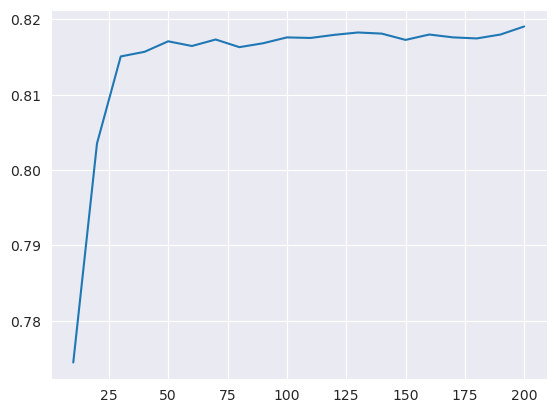

In [56]:
plt.plot(df_scores["n_estimators"], df_scores["auc"])
plt.show()

The AUC-values plateau somewhat a about $50$ trees. Since a `RandomForestClassifier` uses `DecisionTreeClassifier`-models as "Experts", we have to optimize again the parameters `max_depth` and `min_samples_leaf`.

In [57]:
scores = []
rs = 1

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=rs)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((d, n, auc))

In [58]:
columns = ["max_depth", "n_estimators", "auc"]
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.head()

,max_depth,n_estimators,auc
0,5,10,0.787699
1,5,20,0.797731
2,5,30,0.800305
3,5,40,0.799708
4,5,50,0.799878


Plotting the auc for different depths:

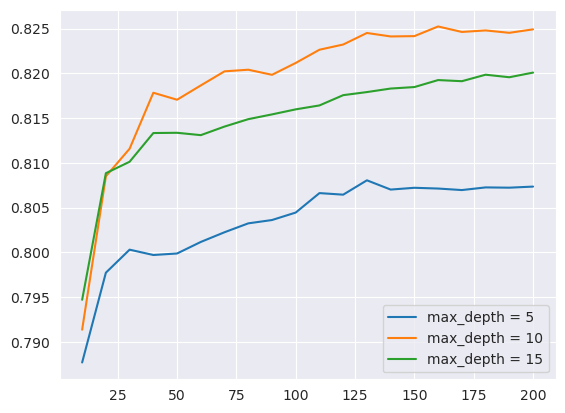

In [59]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores["max_depth"] == d]
    plt.plot(df_subset["n_estimators"], df_subset["auc"], label=f"max_depth = {d}")
plt.legend()
plt.show()
    

From the graph you can see, that the parameter `max_depth=10` givest the best prediction-results.

Tuning the `min_samples_leaf`-parameter with fixed `max_depth=10`:

In [60]:
max_depth = 10

In [61]:
scores = []
rs = 1

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=rs)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((s, n, auc))

In [62]:
columns = ["min_samples_leaf", "n_estimators", "auc"]
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.head()

,min_samples_leaf,n_estimators,auc
0,1,10,0.791365
1,1,20,0.808496
2,1,30,0.811584
3,1,40,0.817839
4,1,50,0.817058


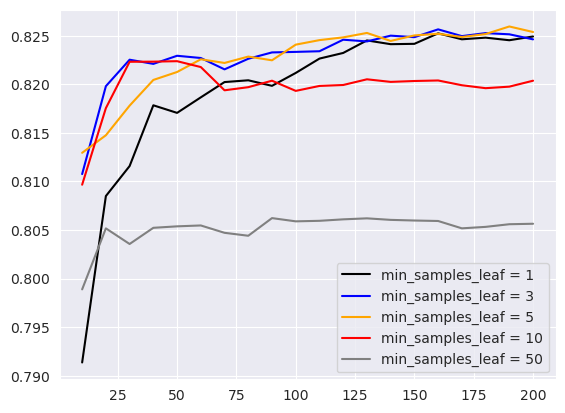

In [63]:
color = ["black", "blue", "orange", "red", "gray"]
min_samples_leaf_value = [1, 3, 5, 10, 50]

for c, s in zip(color, min_samples_leaf_value):
    df_subset = df_scores[df_scores["min_samples_leaf"] == s]
    plt.plot(df_subset["n_estimators"], df_subset["auc"], 
             label=f"min_samples_leaf = {s}",
             color=c)
plt.legend()
plt.show()

From the graph you can see that the black, the blue and the orange lines (1, 3, 5) yield relatively good results when using many experts, however using more experts also means more computational ressources needed. With this in mind, the range of 50 to 100 experts is preferrable.

The optimal parameter `min_samples_leaf=3` is chosen for the next computations:

In [64]:
min_samples_leaf = 3

print("n_estimators = ", n)
print("max_depth = ", max_depth)
print("min_samples_leaf = ", min_samples_leaf)
print("random_state = ", rs)

n_estimators =  200
max_depth =  10
min_samples_leaf =  3
random_state =  1


In [65]:
rf = RandomForestClassifier(n_estimators=n,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1)
rf.fit(X_train, y_train)

y_pred = rf.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print(f"AUC = {auc:.4f}")

AUC = 0.8246


Other useful parameters:
- `max_features`
- `bootstrap`

Link to Documentation: [sklearn.ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

## 6.7 Gradient boosting and XGBoost

- Gradient boosting vs random forest
- Installing `XGBoost`
- Training the first model
- Performance monitoring
- Parsing `XGBoost`'s monitoring output

- `Gradient Boosting` is a different way of ensambling machine learning models that trains them sequentially instead in parallel

### Gradient Boosting vs Random Forest

- **Random Forest:** Random Forests train multiple independent <u>models in parallel</u> and aggregate the prediction results to obtain a final prediction
<img src="../imgs/rf_ensemble.jpg" style="width: 600px">

- **Boosting:** Starts with a dataset and trains a model. After evaluation of the model we see, that there are errors present. Based on these errors, we train another model to handle them. This will also still have some errors left. This process of sequentially training and improving models can be repeated arbitrarily long. The results from all predictions then are aggregated to a final prediction.
<img src="../imgs/boosting_ensemble.jpg" style="width: 600px">

- **In this subsection:** Gradient Boosted Trees

### Installing `XGBoost`

- For Gradient Boosting the python library `XGBoost` is used

In [66]:
# !pip install xgboost

In [67]:
import xgboost as xgb

`XGBoost`-models require a little bit of pre-processing:

In [68]:
# DMatrix: data-structure optimized to be used in xgboost-models
features = dv.get_feature_names_out().tolist()

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [69]:
xgb_params = {
    "eta": 0.3,             # learning rate
    "max_depth": 6,         # controls size in `DecisionTreeClassifier`
    "min_child_weight": 1,
    
    "objective": "binary:logistic", # specification of model type
    "nthread": 8,                   # number of threads used for training

    "seed": 1,      # random seed
    "verbosity": 1, # show only warnings
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200)

In [70]:
y_pred = model.predict(dval)
print(y_pred.shape)
auc = roc_auc_score(y_val, y_pred)

(891,)


A pretty good result

In [71]:
print(f"AUC(XGBOOST): {auc:.4f}")

AUC(XGBOOST): 0.8072


It is possible to evaluate every intermediate model in `XGBoost`:

In [72]:
watchlist = [(dtrain, "train"), (dval, "val")]

In [73]:
from contextlib import redirect_stdout
from io import StringIO

In [74]:
# captures the output to use later. XGBoost only prints but does not provide the eval-data in any usable form
# %%capture output  ## <- somehow does not work

captured_output = StringIO()


xgb_params = {
    "eta": 0.3,             # learning rate
    "max_depth": 6,         # controls size in `DecisionTreeClassifier`
    "min_child_weight": 1,
    
    "objective": "binary:logistic", # specification of model type
    "eval_metric": "auc",           # auc as shown metric
    "nthread": 8,                   # number of threads used for training

    "seed": 1,      # random seed
    "verbosity": 1, # show only warnings
}

with redirect_stdout(captured_output):
    model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                      verbose_eval=5,
                      evals=watchlist)

In [75]:
s = captured_output.getvalue()
print('\n'.join(s.split("\n")[:2])) # looks good

[0]	train-auc:0.86730	val-auc:0.77938
[5]	train-auc:0.93086	val-auc:0.80858


Parsing the output to get the data from it:

In [76]:
line = s.split("\n")[0]

In [77]:
num_iter, train_auc, val_auc = line.split("\t")
print(num_iter, train_auc, val_auc)

[0] train-auc:0.86730 val-auc:0.77938


In [78]:
print(int(num_iter.strip("[]")), float(train_auc.split(":")[1]), float(val_auc.split(":")[1]))

0 0.8673 0.77938


In [79]:
def parse_xgb_output(output):
    results = []
    
    for line in output.strip().split("\n"): # list of all lines
        it_line, train_line, val_line = line.split("\t")
        
        it = int(it_line.strip("[]"))
        train = float(train_line.split(":")[1])
        val = float(val_line.split(":")[1])
            
        results.append((it, train, val))
        
    columns = ["num_iter", "train_auc", "val_auc"]
    df_results = pd.DataFrame(results, columns=columns)
    
    return df_results

In [80]:
df_score = parse_xgb_output(s)
df_score

,num_iter,train_auc,val_auc
0,0,0.86730,0.77938
1,5,0.93086,0.80858
2,10,0.95447,0.80851
3,15,0.96554,0.81334
4,20,0.97464,0.81729
5,25,0.97953,0.81686
6,30,0.98579,0.81543
7,35,0.99011,0.81206
8,40,0.99421,0.80922
9,45,0.99548,0.80842


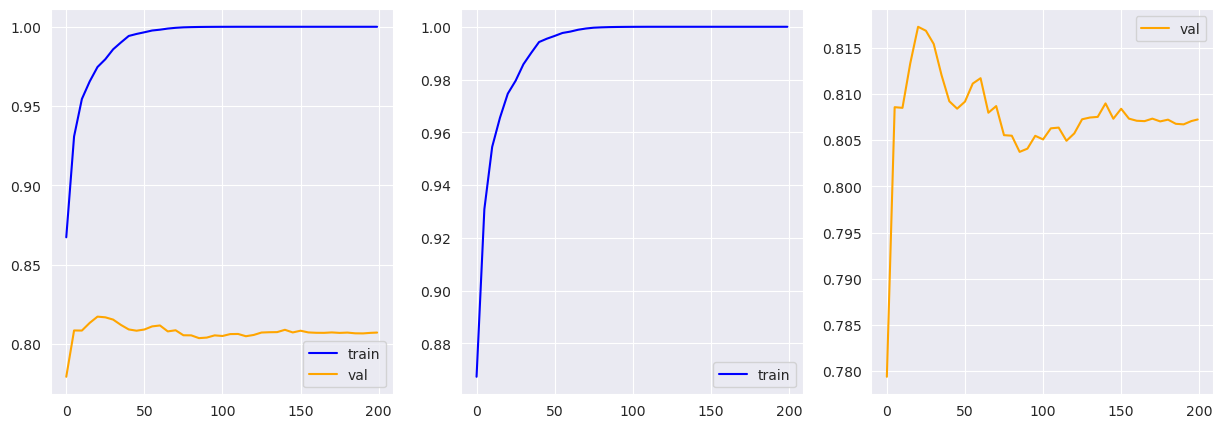

In [81]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].plot(df_score["num_iter"], df_score["train_auc"], label="train", color="blue")
ax[0].plot(df_score["num_iter"], df_score["val_auc"], label="val", color="orange")
ax[0].legend()

ax[1].plot(df_score["num_iter"], df_score["train_auc"], label="train", color="blue")
ax[1].legend()

ax[2].plot(df_score["num_iter"], df_score["val_auc"], label="val", color="orange")
ax[2].legend()

plt.show()

From the plot on the left, one can see that the auc on the validation data deteriorates after 50 iterations of gradient boosting. One remedy to overfitting is to find better hyperparameter, that dont lead the model to overfit.

## 6.8 XGBoost parameter tuning

Tuning the following parameters (in this order):
1. **`eta`**: learning rate = size of step
2. **`max_depth`**: `max_depth` in Random Forests
3. **`min_child_weight`**: `min_samples_leaf` in Random Forests

In [82]:
# captures the output to use later. XGBoost only prints but does not provide the eval-data in any usable form
# %%capture output  ## <- somehow does not work

captured_output = StringIO()


xgb_params = {
    "eta": 0.05,             # learning rate
    "max_depth": 6,         # controls size in `DecisionTreeClassifier`
    "min_child_weight": 1,
    
    "objective": "binary:logistic", # specification of model type
    "eval_metric": "auc",           # auc as shown metric
    
    "nthread": 8,                   # number of threads used for training
    "seed": 1,      # random seed
    "verbosity": 1, # show only warnings
}

with redirect_stdout(captured_output):
    model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                      verbose_eval=5,
                      evals=watchlist)

### 1. Tuning `eta`

In [83]:
scores = {}

In [84]:
output = captured_output.getvalue()

In [85]:
key = f"eta={str(xgb_params['eta'])}"
scores[key] = parse_xgb_output(output)

In [86]:
etas = ["eta=1.0", "eta=0.3", "eta=0.1"]

for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score["num_iter"], df_score["val_auc"], label=eta)
plt.legend()
plt.show()

KeyError: 'eta=1.0'

**Observations:**
- **`General`**: plateauing or even decreasing AUC's are an indication for overfitting of the model
- **`eta=1.0`**: The AUC jumps around and does not really improve. This is a sign of step-size that is too large and therefore the algorithm does not converge to a good solution.
- **`eta=0.3`**: The AUC is better than the with `eta=1.0`, however too large step-size does not let the algorithm find a good optimum 
- **`eta=0.01`**: A good step-size that does small steps and is therefore unlikely to jumpy over optima of the optimization problem that is the machine learning algorithm

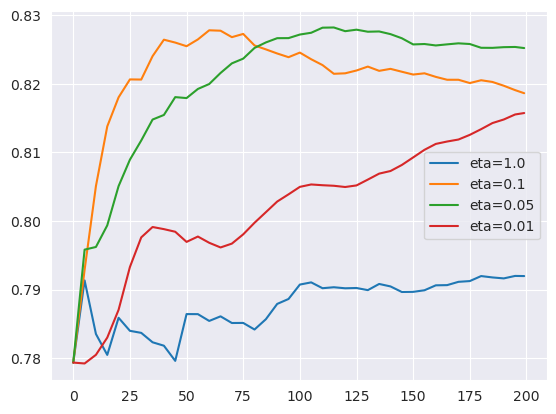

In [ ]:
etas = ["eta=1.0", "eta=0.1", "eta=0.05", "eta=0.01"]

for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score["num_iter"], df_score["val_auc"], label=eta)
plt.legend()
plt.show()

**Observations:**
- **`General`**: plateauing or even decreasing AUC's are an indication for overfitting of the model
- **`eta=1.0`**: same as in previous plot
- **`eta=0.1`**: same as in previous plot
- **`eta=0.05`**: Good tradeoff between small `eta` and training time. The model has a higher AUC than the `eta=0.01`-model while having the same parameters and iterations
- **`eta=0.01`**: The AUC grows continuously. The step-size of the optimization problem is very slow but steady. A downside is, that the algorithm takes considerably longer to converge to a good solution

**Final Choice**:
- The chosen model uses: `eta=0.1`, `num_iter=60` (approximately)

### 2. Tuning `max_depth`

In [ ]:
captured_output = StringIO()

xgb_params = {
    "eta": 0.1,             # learning rate
    "max_depth": 10,         # controls size in `DecisionTreeClassifier`
    "min_child_weight": 1,
    
    "objective": "binary:logistic", # specification of model type
    "eval_metric": "auc",           # auc as shown metric
    
    "nthread": 8,                   # number of threads used for training
    "seed": 1,      # random seed
    "verbosity": 1, # show only warnings
}

with redirect_stdout(captured_output):
    model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                      verbose_eval=5,
                      evals=watchlist)

In [ ]:
scores = {}

In [ ]:
output = captured_output.getvalue()

In [ ]:
key = f"max_depth={str(xgb_params['max_depth'])}"
scores[key] = parse_xgb_output(output)

max_depth=10


In [ ]:
scores.keys()

dict_keys(['max_depth=3', 'max_depth=6', 'max_depth=4', 'max_depth=10'])

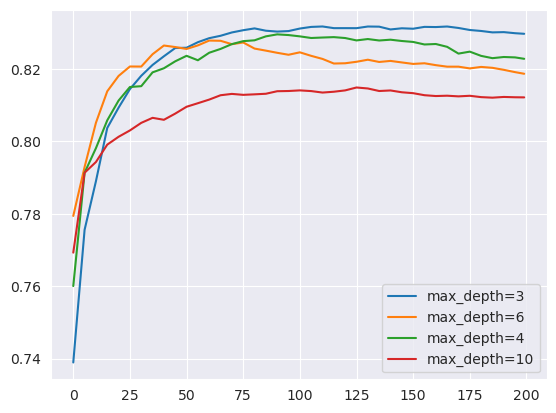

In [ ]:
for max_depth, df_score in scores.items():
    plt.plot(df_score["num_iter"], df_score["val_auc"], label=max_depth)
plt.legend()
plt.show()

The AUC-results of `max_depth=10` over time is significantly lower than the other possible values and is therefore dropped.

In [ ]:
del scores["max_depth=10"]

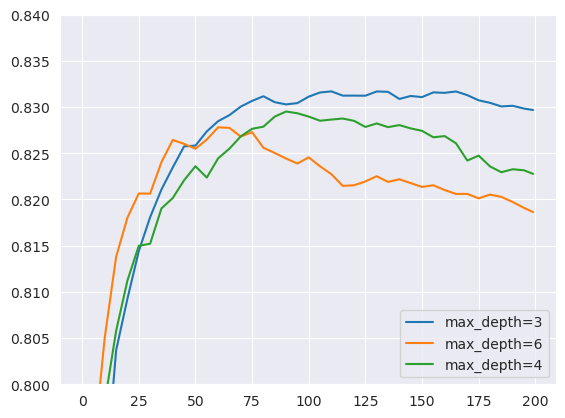

In [ ]:
for max_depth, df_score in scores.items():
    plt.plot(df_score["num_iter"], df_score["val_auc"], label=max_depth)
plt.legend(loc="lower right")
plt.ylim(0.8, 0.84)
plt.show() 

The clear winner here is the model with the parameter `max_depth=3` at about 160 Boosting iterations.

### 3. Tuning `min_child_weight`

In [ ]:
captured_output = StringIO()

xgb_params = {
    "eta": 0.1,             # learning rate
    "max_depth": 3,         # controls size in `DecisionTreeClassifier`
    "min_child_weight": 30,
    
    "objective": "binary:logistic", # specification of model type
    "eval_metric": "auc",           # auc as shown metric
    
    "nthread": 8,                   # number of threads used for training
    "seed": 1,      # random seed
    "verbosity": 1, # show only warnings
}

with redirect_stdout(captured_output):
    model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                      verbose_eval=5,
                      evals=watchlist)

In [ ]:
scores = {}

In [ ]:
output = captured_output.getvalue()

In [ ]:
key = f"min_child_weight={str(xgb_params['min_child_weight'])}"
scores[key] = parse_xgb_output(output)

min_child_weight=30


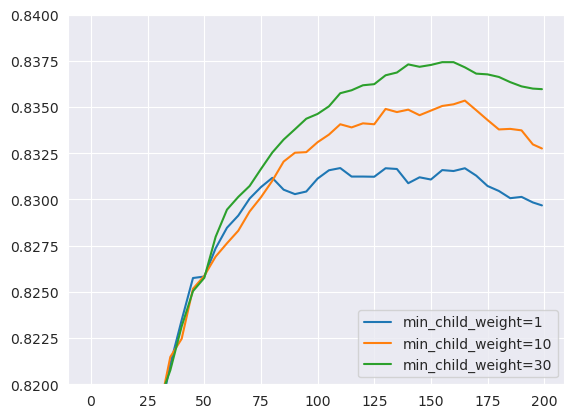

In [ ]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score["num_iter"], df_score["val_auc"], label=min_child_weight)

plt.legend(loc="lower right")
plt.ylim(0.82, 0.84)
plt.show()

Here `min_child_weight=30` yielded the best result

### Using the hyperparameter for the model

In [ ]:
captured_output = StringIO()

xgb_params = {
    "eta": 0.1,             # learning rate
    "max_depth": 3,         # controls size in `DecisionTreeClassifier`
    "min_child_weight": 30,
    
    "objective": "binary:logistic", # specification of model type
    "eval_metric": "auc",           # auc as shown metric
    
    "nthread": 8,                   # number of threads used for training
    "seed": 1,      # random seed
    "verbosity": 1, # show only warnings
}

with redirect_stdout(captured_output):
    model = xgb.train(xgb_params, dtrain, num_boost_round=175)

Other parameters: https://xgboost.readthedocs.io/en/latest/parameter.html

Useful ones:
- `subsample` and `colsample_bytree`
- `lambda` and `alpha`

## 6.9 Selecting the final model

- Choosing between xgboost, random forest and decision tree
- Training the final model
- Saving the model

### Choosing between xgboost, random forest and decision tree

Best `Decision Tree` Model

In [87]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

Best `Random Forest` Model

In [88]:
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=10,
                            min_samples_leaf=3,
                            random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,
                       random_state=1)

Best `XGBoost` Model

In [89]:
xgb_params = {
    "eta": 0.1,
    "max_depth": 3,
    "min_child_weight": 30,

    "objective": "binary:logistic",
    "eval_metric": "auc",

    "nthread": 8,
    "seed": 1,
    "verbosity": 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175)

**The Evaluation**

In [90]:
# Decision Tree
y_pred = dt.predict_proba(X_val)[:, 1]
dt_auc = roc_auc_score(y_val, y_pred)

# Random Forest
y_pred = rf.predict_proba(X_val)[:, 1]
rf_auc = roc_auc_score(y_val, y_pred)

# XGBoost
y_pred = model.predict(dval)
xgb_auc = roc_auc_score(y_val, y_pred)

print(f"Decision Tree: {dt_auc:.4f}")
print(f"Random Forest: {rf_auc:.4f}")
print(f"XGBoost:       {xgb_auc:.4f}") # Winner!

Decision Tree: 0.7855
Random Forest: 0.8246
XGBoost:       0.8366


### Training the final model

For training the final model, the whole training data is used. Before the train/val/test-split was used.

In [92]:
df_full_train = df_full_train.reset_index(drop=True)
y_full_train = (df_full_train["status"] == "default").astype(int).values

In [93]:
if "status" in df_full_train.columns:
    del df_full_train["status"]

In [100]:
dicts_full_train = df_full_train.to_dict(orient="records")

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient="records")
X_test = dv.transform(dicts_test)

dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train, 
                         feature_names=dv.get_feature_names_out().tolist())
dtest = xgb.DMatrix(X_test, feature_names=dv.get_feature_names_out().tolist())

**The Final Model**

In [101]:
xgb_params = {
    "eta": 0.1,
    "max_depth": 3,
    "min_child_weight": 30,

    "objective": "binary:logistic",
    "eval_metric": "auc",

    "nthread": 8,
    "seed": 1,
    "verbosity": 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175)

In [102]:
y_pred = model.predict(dtest)
final_auc = roc_auc_score(y_test, y_pred)
print(f"AUC(final) = {final_auc:.4f}")

AUC(final) = 0.8276


The performance of the final model is reasonably good. We can also see, that the `XGBoost`-model gave the best results when working with tabular data. 

## 6.10 Summary

- Decision tree learn if-then-else rule from data
- Finding the best split: select the least impure split. The algorithm can overfit, that's why we control it by limiting the max depth and the size of the group.
- Random forest is a way of combining multiple decision trees. It should habe a diverse set of models to make good predictions
- Gradient boosting trains model sequentially: each model tries to fix errors of the previous model. XGBoost is an implementation of gradient boosting